<a href="https://colab.research.google.com/github/CatIsOutOfTheBag/Probability_and_Statistics/blob/main/Stat_nuances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Стандартное отклонение  обратнопропорционально корню из количества наблюдений

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

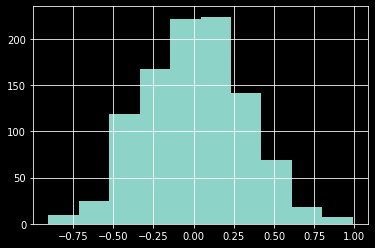

In [ ]:
# 1000 раз считаем среднее для выборки длины 10 из нормального распределения
pd.Series([np.random.normal(size=10).mean() for _ in range(1000)]).hist()


In [ ]:
# выборочное среднее распределено нормально
# теперь посчитаем стандартное отклонение
pd.Series([np.random.normal(size=10).mean() for _ in range(1000)]).std()
# чем больше size, тем меньше std

0.3096137820802302

In [ ]:
# посмотрим с какой скоростью уменьшается стандартное отклонение - ЗБЧ набирает силу
from tqdm.notebook import tqdm
stds = [pd.Series([np.random.normal(size=i).mean() for _ in range(1000)]).std() for i in tqdm(range(1,1001))]


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
t = pd.DataFrame(stds)

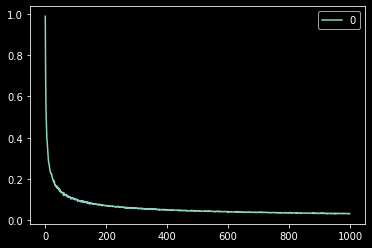

In [ ]:
t.plot();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


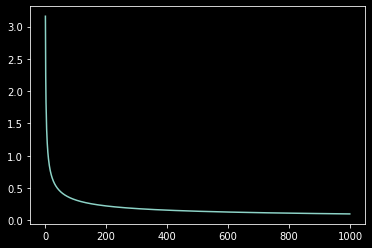

In [ ]:
# видим график, обратно пропорциональный корню из n
# посмотрим на действительный график 1 / корень из n
pd.Series(1 / np.sqrt(np.linspace(0,100,1000))).plot();

#2. Ошибки 1 и 2 рода 
- Инсайт для ошибки первого рода

альфа==0,05 можно трактовать как recall = (1-alpha) = 95%.

Если альфа - это вероятность отвергнуть верную нулевую гипотезу,
то recall - вероятность принять верную нулевую гипотезу
- Инсайт для ошибки второго рода
бетта - это вероятность принять неверную нулевую гипотезу.

(1-betta) = мощность = вероятность отвергнуть неверную нулевую гипотезу (естественно при условии, что альтернативная гипотеза верна)

# 3. Нахождение p_value регрессионным анализом

In [ ]:
# Выборки из биномиального распеделения
baseline = 0.2
sample_size = 1090
mde = 0.05
a = np.random.binomial(1, baseline, size=sample_size)
b = np.random.binomial(1, baseline + 0.01, size=sample_size)

In [ ]:
# группа а будет нулевая группа(0), группа b будет 1
a = pd.DataFrame(a)
a['group'] = 0

In [ ]:
a

,0,group
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0
...,...,...
1085,0,0
1086,0,0
1087,0,0
1088,0,0


In [ ]:
b = pd.DataFrame(b)
b['group'] = 1

In [ ]:
b

,0,group
0,0,1
1,0,1
2,1,1
3,0,1
4,0,1
...,...,...
1085,1,1
1086,0,1
1087,0,1
1088,1,1


In [ ]:
# соединим группы
df = pd.concat([a,b])

In [ ]:
# здесь group - единственная фича, колонка [0] - таргет
df

,0,group
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0
...,...,...
1085,1,1
1086,0,1
1087,0,1
1088,1,1


In [ ]:
# коверсия в нулевой и первой группе
df.groupby('group')[0].agg(['count', 'mean'])

,count,mean
group,,
0,1090,0.188073
1,1090,0.256881


In [ ]:
# посмотрим, будет ли значимый коэффициент при фиче = он же p_value
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
df['const'] = 1 # свободный член

In [ ]:
df

,0,group,const
0,0,0,1
1,0,0,1
2,1,0,1
3,0,0,1
4,0,0,1
...,...,...,...
1085,1,1,1
1086,0,1,1
1087,0,1,1
1088,1,1,1


In [ ]:
logit_mod = sm.Logit(df[[0]], df[['group', 'const']])
logit_res = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.494609
         Iterations 5


In [ ]:
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:                      0   No. Observations:                 2180
Model:                          Logit   Df Residuals:                     2178
Method:                           MLE   Df Model:                            1
Date:                Sun, 07 Aug 2022   Pseudo R-squ.:               3.376e-05
Time:                        17:23:19   Log-Likelihood:                -1078.2
converged:                       True   LL-Null:                       -1078.3
Covariance Type:            nonrobust   LLR p-value:                    0.7873
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
group          0.0291      0.108      0.270      0.787      -0.182       0.241
const         -1.4269      0.077    -18.613      0.000      -1.577      -1.277


In [ ]:
# здесь p_value = вероятность того, что коэф-т больше нуля по случайности

In [ ]:
# Теперь проведем обычный Z-test для этих двух групп
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
proportions_ztest([sum(a[0]), sum(b[0])], [len(a[0]), len(b[0])], alternative = 'two-sided')

(-0.2698319398591239, 0.7872895494588652)

In [ ]:
# видим одинаковые значения